# Preparação e Configuração do Ambiente Kafka

In [1]:
#Checando a versão Java instalada
!java -version

openjdk version "11.0.22" 2024-01-16
OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1)
OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)


In [2]:
#Instalando Java 8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# -q, quiet level 2: no output except for errors
#> /dev/null on the end of any command where you want to redirect all the stdout into nothingness

In [3]:
#Mudando a versão do Java para usar como padrão
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


In [4]:
#Mudando a versão do javac para usar como padrão
!update-alternatives --set javac /usr/lib/jvm/java-8-openjdk-amd64/bin/javac

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/bin/javac to provide /usr/bin/javac (javac) in manual mode


In [5]:
#Mudando a versão do jps para usar como padrão
!update-alternatives --set jps /usr/lib/jvm/java-8-openjdk-amd64/bin/jps

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/bin/jps to provide /usr/bin/jps (jps) in manual mode


In [6]:
#Checando a versão de Java padrão
!java -version

openjdk version "1.8.0_392"
OpenJDK Runtime Environment (build 1.8.0_392-8u392-ga-1~22.04-b08)
OpenJDK 64-Bit Server VM (build 25.392-b08, mixed mode)


In [7]:
#Encontrando o caminho Java padrão
!readlink -f /usr/bin/java | sed "s:bin/java::"

/usr/lib/jvm/java-8-openjdk-amd64/jre/


**Configuração de variáveis de ambiente**

In [8]:
#importando o módulo OS
import os
#Criando as variáveis de ambiente
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["JRE_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64/jre"
os.environ["PATH"] += ":$JAVA_HOME/bin:$JRE_HOME/bin:$HADOOP_HOME/bin:$HADOOP_HOME/sbin"

**Download e instalação do Kafka**

In [9]:
#Baixar e descompactar o Kafka (5 minutos)
!curl -sSOL https://archive.apache.org/dist/kafka/3.4.0/kafka_2.13-3.4.0.tgz
!tar -xzf kafka_2.13-3.4.0.tgz
#Remover o arquivo compactado
!rm kafka_2.13-3.4.0.tgz

Copiando a intalação Kafka para o local padrão

In [10]:
#Copiando os arquivos do kafka para user/local
!cp -r kafka_2.13-3.4.0 /usr/local/
#-r copia diretórios recursivamente

**Iniciandos os serviços com as configurações padrão**

In [11]:
#Usando as configurações padrão (fornecidas pelo Apache Kafka) para ativar as instâncias do Zookeper e do Kafka.
!./kafka_2.13-3.4.0/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-3.4.0/config/zookeeper.properties
!./kafka_2.13-3.4.0/bin/kafka-server-start.sh -daemon ./kafka_2.13-3.4.0/config/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10

Waiting for 10 secs until kafka and zookeeper services are up and running


Verificando se os dois processos zookeeper e kafka estão em execução.

In [12]:
#Lista de processos
!ps -ef | grep kafka

root        1355     177  0 13:19 ?        00:00:00 /bin/bash -c ps -ef | grep kafka
root        1357    1355  0 13:19 ?        00:00:00 grep kafka


**Instalando a biblioteca Pyhton-Kafka**

In [13]:
!pip install kafka-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.5/246.5 kB 4.1 MB/s eta 0:00:00


# Ingestão dos dados de log para pré-processamento e preparação antes da transmissão.

Extraindo o zip com os arquivos que formam a base de dados original

In [14]:
!unzip 'Netflix_WatchLog_Kaggle.zip'

Archive:  Netflix_WatchLog_Kaggle.zip
  inflating: All_Clickstream.csv     
  inflating: All_Devices.csv         
  inflating: All_Profiles.csv        
  inflating: All_SearchHistory.csv   
  inflating: All_ViewingActivity.csv  


Lendo os dados com os logs das atividades de visualização de cada título pelo usuário e transformando para o formado json.

In [15]:
import csv
import json

with open('All_ViewingActivity.csv', 'r') as f:
  reader = csv.DictReader(f)
  data_logs = []
  for row in reader:
    data_logs.append(row)

f.close()
del reader, row, f

Analisando a estrutura do arquivo json

In [16]:
# Exemplo da estrutura json para um registro de log
data_logs[0]

{'Profile Name': 'User 1',
 'Start Time': '2022-04-28 16:08:56',
 'Duration': '00:00:06',
 'Attributes': '',
 'Title': 'Chernobyl 1986',
 'Supplemental Video Type': '',
 'Device Type': 'Device Type 1',
 'Bookmark': '01:02:16',
 'Latest Bookmark': '01:02:16',
 'Country': 'IN (India)'}

# Configuração e Integração para Envio das Mansagens (Producer_Consumer Kafka)

Criação do Tópico

In [17]:
#Importa as funções do Python-Kafka
from kafka.admin import KafkaAdminClient, NewTopic

# Cria uma instância do KafkaAdminClient
admin_client = KafkaAdminClient(bootstrap_servers="localhost:9092", client_id='client1')

#Cria uma lista para receber os tópicos
topic_list = []

#Lista o tópico
topic_list.append(NewTopic(name="DataLog_Netflix", num_partitions=1, replication_factor=1))

#Cria o tópico
admin_client.create_topics(new_topics=topic_list, validate_only=False)

CreateTopicsResponse_v3(throttle_time_ms=0, topic_errors=[(topic='DataLog_Netflix', error_code=0, error_message=None)])

LIstando os Tópicos

In [18]:
topics = admin_client.list_topics()

print(topics)

['DataLog_Netflix']


Verificando as informações sobre o tópico

In [19]:
#Busca detalhes do tópico
topic_details = admin_client.describe_topics(['DataLog_Netflix'])

#Imprime as informações obtidas
print(topic_details)

[{'error_code': 0, 'topic': 'DataLog_Netflix', 'is_internal': False, 'partitions': [{'error_code': 0, 'partition': 0, 'leader': 0, 'replicas': [0], 'isr': [0], 'offline_replicas': []}]}]


Verificando a quantidade de logs - mensagens que serão enviadas através do Kafka

In [20]:
print(len(data_logs))

9992


Produzindo Mensagem

In [21]:
from kafka import KafkaProducer

#Variáveis do kafka
kafka_brokers = ["localhost:9092"]
topic_name = "DataLog_Netflix"

#Inicializa o produtor
producer = KafkaProducer(bootstrap_servers=kafka_brokers,
                         value_serializer=lambda v: json.dumps(v).encode('utf-8'))

count = 0
#Envia uma mensagem
for message in data_logs:
  producer.send(topic_name, value=message)
  count+=1

#Garante que todas as mensagens pendentes sejam enviadas e trata qualquer erro
producer.flush()

Consumindo Mensagem

In [23]:
from kafka import KafkaConsumer

#Variáveis do kafka
kafka_brokers = ["localhost:9092"]
topic_name = "DataLog_Netflix"

#Inicializa o consumidor com um group_id
consumer = KafkaConsumer(
    topic_name,
    bootstrap_servers=kafka_brokers,
    auto_offset_reset='earliest',  #Começa a ler desde o início do tópico
    group_id='client1', #Especifica um group_id para o consumidor
    consumer_timeout_ms=5000,  # Sair do loop após 5 segundos sem mensagens
    value_deserializer=lambda x: json.loads(x.decode('utf-8'))
)

message_rec = []

#Lê e imprime a primeira mensagem recebida
for i in consumer:
    message_rec.append(i.value)

#Fechar o consumidor quando terminar
consumer.close()

#Deletando algumas das variáveis
del count, i, message, topic_details, topic_list, topic_name, topics

Validando a quantidade de mensagens recebidas pelo consumidor:

In [33]:
print(len(message_rec))

9992


# Análise dos Dados e Carregamento do Resultados - Analytics

In [34]:
# Analisar a duração média que cada usuário assiste aos títulos na Netflix.
# Analisar o tempo total assitido pelo usuário em função do dia da semana.

import datetime

# Esta variável representa a lista com os dados que serão analisados para responder às questões analíticas formuladas.
# Dados armazenados: 'User', 'Title', 'Date','Duration Hour', 'Duration Minute', 'Duration Second', 'Total in Minutes'
titles_viwed_lst = []

for i in message_rec:
  # obter o id do usuário:
  user_id = i['Profile Name']

  # obter o nome do título assistido:
  title_vw = i['Title']

  # obter somente a data no formato y-m-d (ano-mês-dia):
  date_vw = datetime.datetime.strptime(i['Start Time'], '%Y-%m-%d %H:%M:%S').date()

  # calcular o tempo de visualização de cada título:
  duration_vw = datetime.datetime.strptime(i['Duration'], '%H:%M:%S')
  total_minutes_vw = round(int(duration_vw.hour)*60 + int(duration_vw.minute) + int(duration_vw.second)/60, 4)

  # gravar dados na lista
  titles_viwed_lst.append([user_id, title_vw, date_vw, duration_vw.hour, duration_vw.minute, duration_vw.second, total_minutes_vw])

del user_id, total_minutes_vw, title_vw, i, duration_vw, date_vw

In [35]:
# Transformação da lista num DataFrame Pandas para análise e resposta às questões analíticas

import pandas as pd

ViewActivity_df = pd.DataFrame(titles_viwed_lst, columns=['User', 'Title', 'Date','Duration Hour', 'Duration Minute', 'Duration Second', 'Total in Minutes'])
ViewActivity_df.head()

,User,Title,Date,Duration Hour,Duration Minute,Duration Second,Total in Minutes
0,User 1,Chernobyl 1986,2022-04-28,0,0,6,0.10
1,User 1,13 Hours: The Secret Soldiers of Benghazi,2022-04-28,0,9,39,9.65
2,User 1,Saving Private Ryan,2022-04-28,0,0,6,0.10
3,User 1,Mosul,2022-04-28,0,0,15,0.25
4,User 1,12 Strong,2022-04-28,0,1,45,1.75


In [36]:
# Analisando os resulatdos:
ViewActivity_df.describe()

,Duration Hour,Duration Minute,Duration Second,Total in Minutes
count,9992.000000,9992.000000,9992.000000,9992.000000
mean,0.030624,12.646417,25.066553,14.901664
std,0.197732,14.184310,17.710278,19.259993
min,0.000000,0.000000,0.000000,0.016700
25%,0.000000,0.000000,8.000000,0.533300
50%,0.000000,8.000000,23.000000,8.550000
75%,0.000000,21.000000,40.000000,21.616700
max,2.000000,59.000000,59.000000,176.666700


In [37]:
# Questão 01:
# Analisar a duração média que cada usuário assiste aos títulos na Netflix.

usergroup_duration_df = ViewActivity_df.groupby('User')['Total in Minutes'].mean()
usergroup_duration_df

User
User 0    14.486591
User 1    11.483333
User 2    19.126518
User 3    14.914688
User 4    16.610788
User 5     9.047889
User 6    11.366436
User 7    13.625592
User 8    14.317738
Name: Total in Minutes, dtype: float64

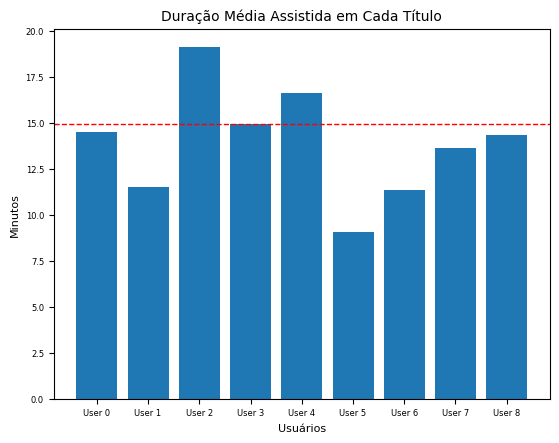

In [38]:
import matplotlib.pyplot as plt

# Obtendo o valor médio total dos minutos assistidos:
mean_vw = ViewActivity_df.describe()['Total in Minutes']

plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

plt.bar(usergroup_duration_df.index, usergroup_duration_df.values)
plt.xlabel("Usuários")
plt.ylabel("Minutos")
plt.title("Duração Média Assistida em Cada Título", fontsize=10)
plt.axhline(y=mean_vw['mean'], color='red', linestyle='dashed', linewidth=1)
plt.show()

In [45]:
# Questão 02:
# Analisar o tempo total assitido pelos usuários em função do dia da semana.

# Manipulando o Dataframe original para um novo dataframe com as datas para conversão em dias da semana e total de minutos:
weekly_views_df = ViewActivity_df.drop(['User', 'Title', 'Duration Hour', 'Duration Minute', 'Duration Second'], axis='columns')
weekly_views_df['Date Format'] = pd.to_datetime(ViewActivity_df['Date'])
weekly_views_df['weekday'] = weekly_views_df['Date Format'].dt.strftime('%A')
#weekly_views_df['weekday_id'] = weekly_views_df['Date Format'].dt.strftime('%w')

weekly_views_df = weekly_views_df.drop(['Date', 'Date Format'], axis='columns')

# Definindo um dicionário para ordenar os dias da semana
weekday_map = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3,
    "Friday": 4,
    "Saturday": 5,
    "Sunday": 6
}


grouped_weekly = weekly_views_df.groupby('weekday').sum().reset_index()
grouped_weekly['weekday_id'] = list(map(lambda x : weekday_map.get(x), grouped_weekly['weekday'] ))
grouped_weekly = grouped_weekly.sort_values('weekday_id').reset_index()
grouped_weekly = grouped_weekly.drop(['index', 'weekday_id'] , axis='columns')
grouped_weekly

,weekday,Total in Minutes
0,Monday,19891.1663
1,Tuesday,19062.1355
2,Wednesday,18268.6690
3,Thursday,17695.0657
4,Friday,20804.5845
5,Saturday,23455.8840
6,Sunday,29719.9180


In [65]:
total_weekend = grouped_weekly['Total in Minutes'][5:7].sum()
total_week = grouped_weekly['Total in Minutes'][0:5].sum()

print(f'Percentual duração nos finais de semana: {total_weekend/total_week: .4f}')

Percentual duração nos finais de semana:  0.5555


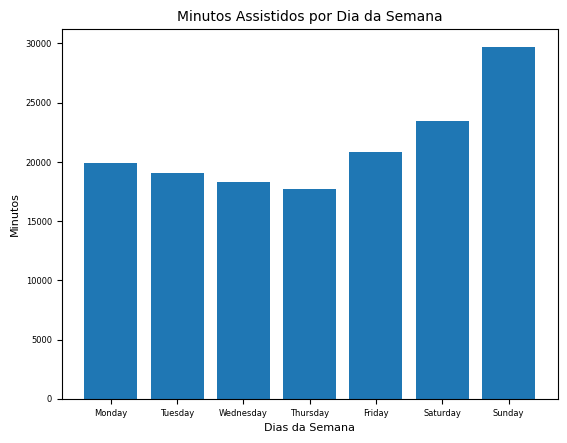

In [46]:
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

plt.bar(grouped_weekly['weekday'], grouped_weekly['Total in Minutes'])
plt.xlabel("Dias da Semana")
plt.ylabel("Minutos")
plt.title("Minutos Assistidos por Dia da Semana", fontsize=10)


plt.show()

In [47]:
ViewActivity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9992 entries, 0 to 9991
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   User              9992 non-null   object 
 1   Title             9992 non-null   object 
 2   Date              9992 non-null   object 
 3   Duration Hour     9992 non-null   int64  
 4   Duration Minute   9992 non-null   int64  
 5   Duration Second   9992 non-null   int64  
 6   Total in Minutes  9992 non-null   float64
dtypes: float64(1), int64(3), object(3)
memory usage: 546.6+ KB


In [48]:
# Salvando os resultados das análises em arquivos csv

usergroup_duration_df.to_csv('usergroup_duration.csv')
grouped_weekly.to_csv('grouped_weekly.csv', index=False)